# Dependencies for SAM2 and MediaPipe

In [42]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

1. Mediapipe

In [ ]:
!pip install -q mediapipe
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

2. SAM2

In [3]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

# !mkdir -p videos
# !wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
# !unzip -d videos videos/bedroom.zip

!mkdir -p ../checkpoints/
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-1f9bf6ht
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-1f9bf6ht
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.7 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=SAM_2-1.0-cp311-c

In [4]:
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

--2025-01-25 23:23:49--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.239.50.18, 18.239.50.104, 18.239.50.120, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.239.50.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 898083611 (856M) [application/vnd.snesdev-page-table]
Saving to: ‘../checkpoints/sam2.1_hiera_large.pt’

sam2.1_hiera_large. 100%[===================>] 856.48M  37.7MB/s    in 14s     

2025-01-25 23:24:03 (62.9 MB/s) - ‘../checkpoints/sam2.1_hiera_large.pt’ saved [898083611/898083611]



# Extracting all frames from given test video

In [6]:
# Create a directory to store the extracted frames
!mkdir -p test_video
!ffmpeg -i test.mp4 -q:v 2 -start_number 0 test_video/'%05d.jpg'

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

# Part1:
# Getting data from mediapipe model:
# 1. bounding box of hand
# 2. coordinates of the hand

Setup the Mediapipe model

In [7]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

Obtain data using the model

In [8]:
def get_mediapipe_bounding_box(image_path):

    loaded_img = mp.Image.create_from_file(image_path)
    detection_result = detector.detect(loaded_img)

    hand_landmarks_list = detection_result.hand_landmarks  # coordinates of each hand in image as list
    handedness_list = detection_result.handedness  # details about each hand. Not required in our case here

    annotated_image = np.copy(loaded_img.numpy_view())
    height, width, _ = annotated_image.shape

    bounding_box_coords_all = []
    for idx in range(len(hand_landmarks_list)):

        per_hand_bb_coords = []

        hand_landmarks = hand_landmarks_list[idx]

        x_coordinates = [landmark.x for landmark in hand_landmarks]
        y_coordinates = [landmark.y for landmark in hand_landmarks]

        # Calculate the bounding box coordinates based on the hand landmarks
        x_min = int(min(x_coordinates) * width)
        y_min = int(min(y_coordinates) * height)
        x_max = int(max(x_coordinates) * width)
        y_max = int(max(y_coordinates) * height)

        # Store the calculated bounding box coordinates in the dictionary
        per_hand_bb_coords.append(x_min)
        per_hand_bb_coords.append(y_min)
        per_hand_bb_coords.append(x_max)
        per_hand_bb_coords.append(y_max)

        bounding_box_coords_all.append(per_hand_bb_coords)

    return bounding_box_coords_all, height, width  # List of lists if multiple hands are detected


In [9]:
def get_mediapipe_coords(image_path):

    loaded_img = mp.Image.create_from_file(image_path)
    detection_result = detector.detect(loaded_img)

    hand_landmarks_list = detection_result.hand_landmarks  # List of landmarks for each hand
    height, width, _ = loaded_img.numpy_view().shape  # Get the image dimensions

    coords_all = []  # List to store coordinates for each hand

    for hand_landmarks in hand_landmarks_list:
        # Extract x and y coordinates and convert them to pixel values
        hand_coords = []
        for landmark in hand_landmarks:
            x_pixel = int(landmark.x * width)  # Convert x to pixel
            y_pixel = int(landmark.y * height)  # Convert y to pixel
            hand_coords.append([x_pixel, y_pixel])  # Add coordinate pair to list

        # Append the coordinates for the current hand
        coords_all.append(hand_coords)

    return coords_all  # List of lists of pixel coordinates for all hands


# Part2:
# Using SAM2 on data from Part1

Setup the SAM2 model

In [10]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [11]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

Helper Plotting functions

In [39]:
def show_mask(mask, ax, obj_id=None, random_color=False, plot=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if plot:
        ax.imshow(mask_image)
        return
    else:
        return mask_image


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

Extract video and run SAM2 on it

In [25]:
# Get ffmpeg extracted video frames
video_dir = "./test_video"
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 210/210 [00:09<00:00, 23.18it/s]


In [24]:
predictor.reset_state(inference_state)

Functions to generate negative points

In [26]:
def generate_negative_points_anywhere(image_width, image_height, target_bbox, other_bboxes, n, threshold, padding):
    negative_points = set()

    xmin_t, ymin_t, xmax_t, ymax_t = target_bbox

    while len(negative_points) < n:
        x = x = np.random.choice([np.random.randint(0, xmin_t-padding), np.random.randint(xmax_t+padding, image_width)]) # Randomly generate a point (x, y) within the threshold of target bb
        y = np.random.choice([np.random.randint(0, ymin_t-padding), np.random.randint(ymax_t+padding, image_height)])

        # Check if the point is inside any other bounding boxes region
        valid_point = True
        for bbox in other_bboxes:
            xmin, ymin, xmax, ymax = bbox

            # If the point doesn't fall inside any expanded bounding box
            if xmin <= x <= xmax and ymin <= y <= ymax:
                valid_point = False
                break

        if valid_point:
            negative_points.add((x, y))

    return list(negative_points)


In [27]:
def generate_negative_points_close_to_hand(image_width, image_height, target_bbox, other_bboxes, n, threshold, padding):
    negative_points = set()

    # Calculate the expanded bounding box for the target (with threshold)
    xmin_t, ymin_t, xmax_t, ymax_t = target_bbox
    xmin_t_thresh = xmin_t - threshold
    ymin_t_thresh = ymin_t - threshold
    xmax_t_thresh = xmax_t + threshold
    ymax_t_thresh = ymax_t + threshold

    while len(negative_points) < n:
        # Randomly generate a point (x, y) within the threshold of target bb but outside bb (bb includes padding)
        x = x = np.random.choice([np.random.randint(xmin_t_thresh, xmin_t-padding), np.random.randint(xmax_t+padding, xmax_t_thresh)])
        y = np.random.choice([np.random.randint(ymin_t_thresh, ymin_t-padding), np.random.randint(ymax_t+padding, ymax_t_thresh)])

        # Check if the point is inside any other bounding boxes region
        valid_point = True
        for bbox in other_bboxes:
            xmin, ymin, xmax, ymax = bbox

            # If the point doesn't fall inside any expanded bounding box
            if xmin <= x <= xmax and ymin <= y <= ymax:
                valid_point = False
                break

        if valid_point:
            negative_points.add((x, y))


    return list(negative_points)


Use positive points, bounding box points, and negative points to generate segmentation masks

This is the main function

In [28]:
def video_segmentation_from_coords(video_dir, image_num, num_neg_points= 5, coord_threshold=100, padding=30):
    prompts = {}
    ann_frame_idx = image_num  # the frame index we interact with

    frame_names = [
          p for p in os.listdir(video_dir)
          if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
      ]
    frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

    img_path = os.path.join(video_dir, frame_names[ann_frame_idx])

    # Getting all the positive clicks from part1
    positive_points = get_mediapipe_coords(img_path)

    # points= positive_points
    # # for each object
    # for obj_num in range(len(points)):
    #     ann_obj_id = obj_num  # give a unique id to the hand obj
    #     obj_points = np.array(points[obj_num], dtype=np.float32)
    #     obj_labels = np.ones(len(points[obj_num]), dtype=np.int32) # for labels, 1 means positive click and 0 means negative click

    # Other points around bounding box can be taken as negatives
    points = []
    bb_coords, img_height, img_width = get_mediapipe_bounding_box(img_path)
    for idx, bb in enumerate(bb_coords):
      negative_points_1 = generate_negative_points_close_to_hand(img_width, img_height, bb, bb_coords, num_neg_points, coord_threshold, padding)
      negative_points_2 = generate_negative_points_anywhere(img_width, img_height, bb, bb_coords, num_neg_points, coord_threshold, padding)

      # xmin, ymin, xmax, ymax = bb
      # bb_coordinates = [(xmin, ymin), (xmin, ymax), (xmax, ymin), (xmax, ymax)]
      # points.append(positive_points[idx] + bb_coordinates + negative_points_1 + negative_points_2)

      points.append(positive_points[idx] + negative_points_1 + negative_points_2)

    # for each object
    for obj_num in range(len(points)):
        ann_obj_id = obj_num  # give a unique id to the hand obj
        obj_points = np.array(points[obj_num], dtype=np.float32)
        obj_labels = np.ones(len(points[obj_num]), dtype=np.int32) # for labels, 1 means positive click and 0 means negative click
        obj_labels[-2*num_neg_points:] = 0

        prompts[ann_obj_id] = obj_points, obj_labels

        _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=ann_obj_id,
            points=obj_points,
            labels=obj_labels,
        )

    # show the results on the current (interacted) frame on all objects
    plt.figure(figsize=(9, 6))
    plt.title(f"frame {ann_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
    show_points(obj_points, obj_labels, plt.gca())
    for i, out_obj_id in enumerate(out_obj_ids):
        show_points(*prompts[out_obj_id], plt.gca())
        show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

    return

In [35]:
def propagate(video_dir):
    # run propagation throughout the video and collect the results in a dict
    video_segments = {}  # video_segments contains the per-frame segmentation results
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        if len(out_obj_ids) == 0 or len(out_mask_logits) == 0:
            print(f"Warning: No objects or masks for frame {out_frame_idx}. Skipping frame.")
            continue
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }
    return video_segments

In [36]:
def plot_video_segmentation(video_dir, video_segments, vis_frame_stride=30):
    frame_names = [
          p for p in os.listdir(video_dir)
          if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
      ]
    frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

    # render the segmentation results every few frames
    vis_frame_stride = vis_frame_stride
    plt.close("all")
    for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
        plt.figure(figsize=(6, 4))
        plt.title(f"frame {out_frame_idx}")
        plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
    return

In [49]:
def save_video_segmentation(video_dir, video_segments, output_path):
    frame_names = [
        p for p in os.listdir(video_dir)
        if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
    ]
    frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

    # Get frame dimensions from the first frame
    first_frame = Image.open(os.path.join(video_dir, frame_names[0]))
    frame_width, frame_height = first_frame.size

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, 30, (frame_width, frame_height))

    for out_frame_idx in range(0, len(frame_names)):
        frame = np.array(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            mask_image = show_mask(out_mask, None, obj_id=out_obj_id, plot=False)
            mask_image = (mask_image * 255).astype(np.uint8)
            mask_image = cv2.cvtColor(mask_image, cv2.COLOR_RGBA2BGRA)

            # Overlay mask on the frame
            alpha = mask_image[:, :, 3] / 255.0
            for c in range(3):
                frame[:, :, c] = frame[:, :, c] * (1 - alpha) + mask_image[:, :, c] * alpha

        out.write(frame)

    out.release()


Spot correct for frames

The green stars indicate positive points and red stars indicate negative points.

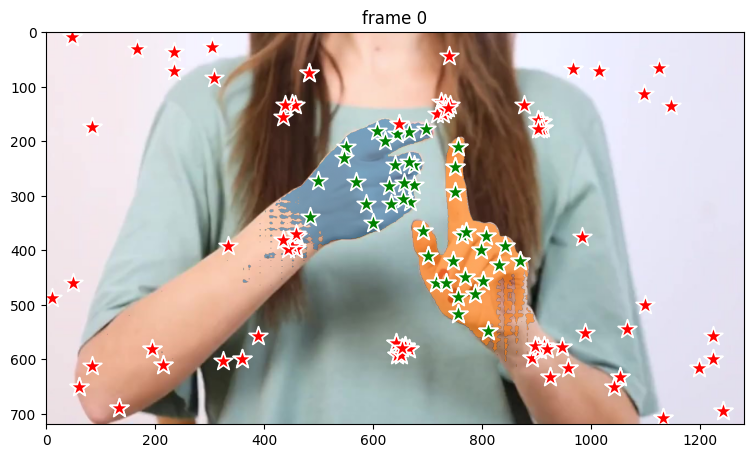

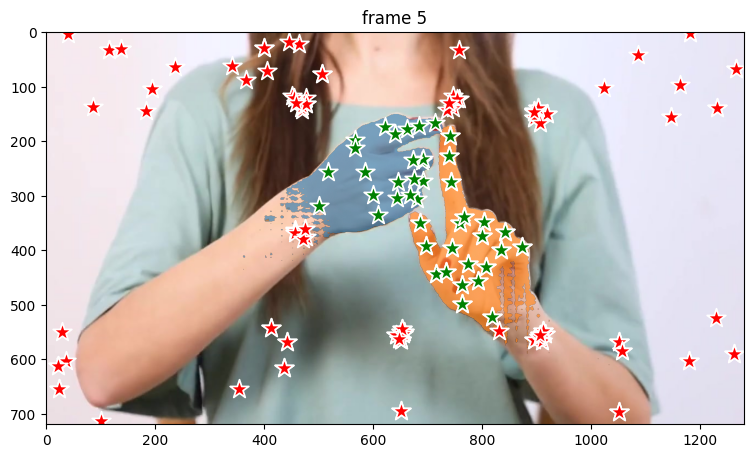

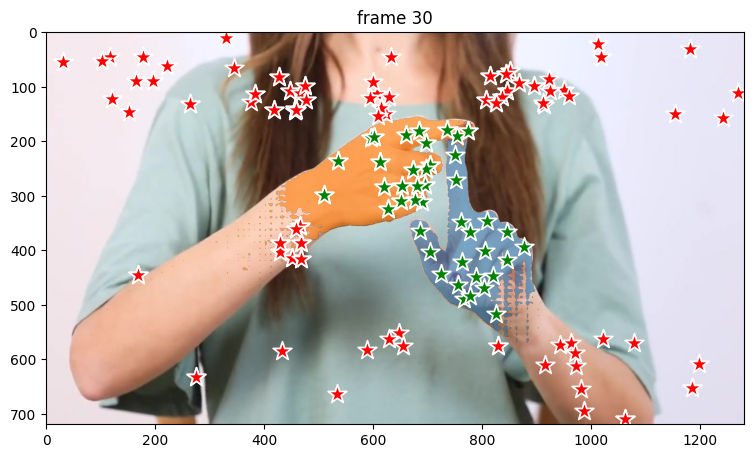

In [30]:
video_segmentation_from_coords("/content/test_video", 0, num_neg_points= 20, coord_threshold=50, padding=20)
video_segmentation_from_coords("/content/test_video", 5, num_neg_points= 20, coord_threshold=50, padding=20)
video_segmentation_from_coords("/content/test_video", 30, num_neg_points= 20, coord_threshold=100, padding=30)

Get for whole video

In [ ]:
video_segments = propagate("/content/test_video")

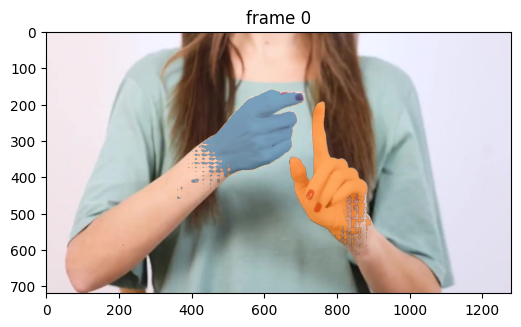

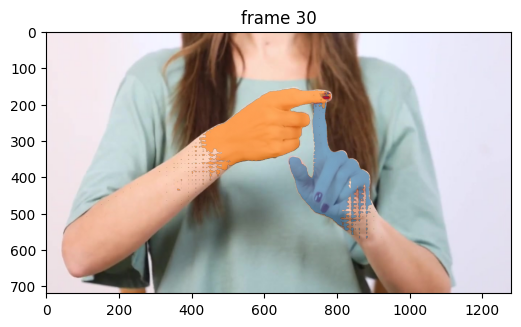

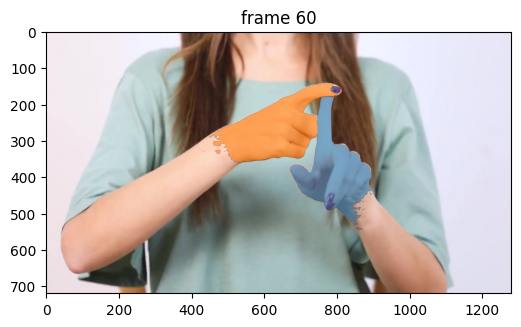

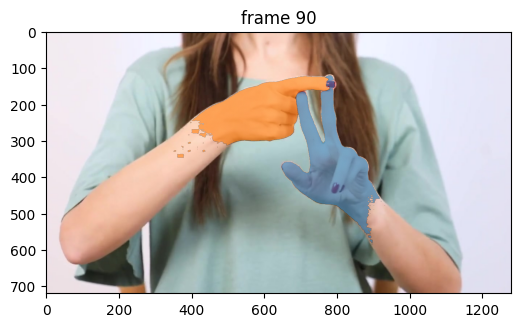

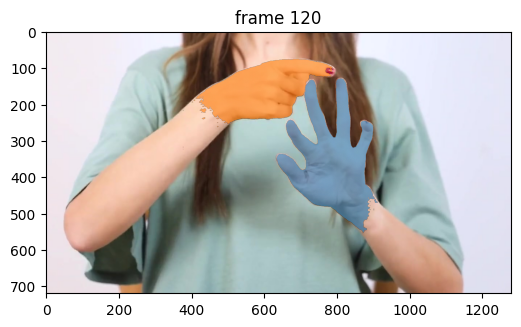

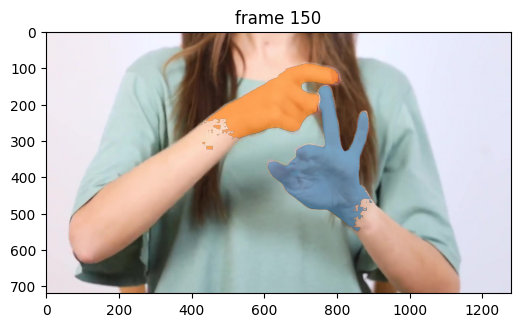

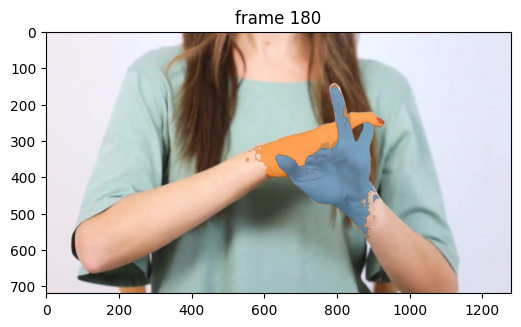

In [40]:
plot_video_segmentation("/content/test_video", video_segments, vis_frame_stride=30)

In [50]:
save_video_segmentation("/content/test_video", video_segments, "/content/output.mp4")